In [863]:
def linear_regression(input_MSA):
    cases_all = pd.read_csv('./data/output_cases.csv')
    travels_all = pd.read_csv('./MSA_travel_aggregate_code/output.csv')
    
    # preprocessing
    cases_list = cases_all.loc[cases_all['name'] == input_MSA]
    cases_list = list(cases_list.iloc[0])
    cases_list.pop(0)
    cases_list.pop(0)
    
    travels_list = travels_all.loc[travels_all['name_msa'] == input_MSA]
    travels_list = list(travels_list.iloc[0])
    travels_list.pop(0)
    
    # push the number of cases to 14 days later so the number of travelers at one day 
    # corresponds to the number of cases 14 days later
    travels_list = np.array(travels_list[:len(travels_list) - 7])
    cases_list = np.array(cases_list[7:])
    
    # split into train and test sets
    travels_train = travels_list[:len(travels_list) - math.floor(0.2 * len(travels_list))]
    travels_test = travels_list[len(travels_list) - math.floor(0.2 * len(travels_list)):]
    
    cases_train = cases_list[:len(cases_list) - math.floor(0.2 * len(cases_list))]
    cases_test = cases_list[len(cases_list) - math.floor(0.2 * len(cases_list)):]
    
    
    # train the model
    travels_train = travels_train.reshape(-1, 1)
    cases_train = cases_train.reshape(-1, 1)
    travels_test = travels_test.reshape(-1, 1)
    cases_test = cases_test.reshape(-1, 1)
    
    model = linear_model.LinearRegression()
    model.fit(travels_train, cases_train)
    
    # predict
    cases_predict = model.predict(travels_train)

    #plt.scatter(travels_test, cases_test, color = 'black')
        
        
    plt.scatter(travels_list, cases_list)
    #plt.plot(travels_train, cases_predict, color = 'red')
    plt.title(input_MSA)
    plt.ylabel('number of Covid-19 cases')
    plt.xlabel('number of travelers')
    
    


In [864]:
def simple_plot(input_MSA, beginDate, endDate):
    cases = pd.read_csv('./data/output.csv')

    row = cases.loc[cases['name_msa'] == input_MSA]
    
    
    list_cases = list(row['cases'])
    list_deaths = list(row['deaths'])
    list_dates = list(row['interval_start'])
    
    
    list_dates_filtered = []
    list_cases_filtered = []
    list_deaths_filtered = []
    
    for i in range(len(list_dates)):
        list_dates[i] = str_to_date(list_dates[i])
    
    #print(list_dates)
    
    for i in range(len(list_dates)):
        if (list_dates[i] >= beginDate and list_dates[i] <= endDate):
            list_dates_filtered.append(list_dates[i])
            list_cases_filtered.append(list_cases[i])
            list_deaths_filtered.append(list_deaths[i])
            
    plt.figure(0)
    plt.figure(figsize=(12,3))
    plt.plot(list_dates_filtered, list_cases_filtered)
    plt.title('Covid-19 cases at ' + input_MSA + ', ' + str(beginDate)[:10] + ' to ' + str(endDate)[:10]) 
    
    plt.figure(1)
    plt.figure(figsize=(12,3))
    plt.plot(list_dates_filtered, list_deaths_filtered)
    plt.title('Covid-19 deaths at ' + input_MSA + ', ' + str(beginDate)[:10] + ' to ' + str(endDate)[:10]) 
    
    
    travels = pd.read_csv('./MSA_travel_aggregate_code/output.csv')       
    list_travels = []
    list_travels_filtered = []
    list_dates_filtered_travels = []
    
    beginDate += timedelta(days = 14)
    endDate += timedelta(days = 14)
    
    for index, row in travels.iterrows():
        if (row['name_msa'] == input_MSA):
            list_travels =  list(row)
            list_travels.pop(0)
            dates = list(travels)
            dates.pop(0)

            for i in range(len(dates)):
                dates[i] = str_to_date(dates[i])
            for i in range(len(dates)):
                if (dates[i] >= beginDate and dates[i] <= endDate):
                    list_travels_filtered.append(list_travels[i])
                    list_dates_filtered_travels.append(dates[i])

            plt.figure(2)
            plt.figure(figsize=(12, 3))
            plt.plot(list_dates_filtered_travels, list_travels_filtered)
            plt.title('Travelers to ' + input_MSA + ', '  + str(beginDate)[:10] + ' to ' + str(endDate)[:10])
            break

In [865]:
def LSTM_test1(input_MSA):
    
    # date-time parsing function for loading the dataset
    def parser(x):
        return dt.strptime('190'+x, '%Y-%m')

    # frame a sequence as a supervised learning problem
    def timeseries_to_supervised(data, lag=1):
        df = DataFrame(data)
        columns = [df.shift(i) for i in range(1, lag+1)]
        columns.append(df)
        df = concat(columns, axis=1)
        df.fillna(0, inplace=True)
        return df

    # create a differenced series
    def difference(dataset, interval=1):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        return Series(diff)

    # invert differenced value
    def inverse_difference(history, yhat, interval=1):
        return yhat + history[-interval]

    # scale train and test data to [-1, 1]
    def scale(train, test):
        # fit scaler
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler = scaler.fit(train)
        # transform train
        train = train.reshape(train.shape[0], train.shape[1])
        train_scaled = scaler.transform(train)
        # transform test
        test = test.reshape(test.shape[0], test.shape[1])
        test_scaled = scaler.transform(test)
        return scaler, train_scaled, test_scaled

    # inverse scaling for a forecasted value
    def invert_scale(scaler, X, value):
        new_row = [x for x in X] + [value]
        array = np.array(new_row)
        array = array.reshape(1, len(array))
        inverted = scaler.inverse_transform(array)
        return inverted[0, -1]

    # fit an LSTM network to training data
    def fit_lstm(train, batch_size, nb_epoch, neurons):
        X, y = train[:, 0:-1], train[:, -1]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        model = Sequential()
        model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        for i in range(nb_epoch):
            model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
            model.reset_states()
        return model

    # make a one-step forecast
    def forecast_lstm(model, batch_size, X):
        X = X.reshape(1, 1, len(X))
        yhat = model.predict(X, batch_size=batch_size)
        return yhat[0,0]

    
    # load the dataset
    df_all = pd.read_csv('./data/output_cases.csv')
    
    cases = df_all.loc[df_all['name'] == input_MSA]
    cases = list(cases.iloc[0])
    cases.pop(0)
    cases.pop(0)
    
    data = {'case':cases}
    dataframe = pd.DataFrame(data)
    
       
    # transform data to be stationary
    raw_values = dataframe.values
    diff_values = difference(raw_values, 1)

    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values

    # split data into train and test-sets
    train, test = supervised_values[:len(supervised_values) - math.floor(0.2 * len(supervised_values))], supervised_values[len(supervised_values) - math.floor(0.2 * len(supervised_values)):]

    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)

    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]
        print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


    rmse = sqrt(mean_squared_error(raw_values[len(raw_values) - math.floor(0.2 * len(raw_values)):], predictions))
    print('Test RMSE: %.3f' % rmse)
    # line plot of observed vs predicted
    plt.plot(raw_values[len(raw_values) - math.floor(0.2 * len(raw_values)):])
    plt.plot(predictions)
    plt.show()

In [866]:
def LSTM_test(input_MSA):
      
    # convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    # fix random seed for reproducibility
    np.random.seed(7)
    
    
    # load the dataset
    df_all = pd.read_csv('./data/output_cases.csv')
    
    cases = df_all.loc[df_all['name'] == input_MSA]
    cases = list(cases.iloc[0])
    cases.pop(0)
    cases.pop(0)
    
    data = {'case':cases}
    dataframe = pd.DataFrame(data)
    
    
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    #plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot, color = 'black')
    plt.show()

In [867]:
def ARIMA_test(input_MSA):
    test_data = pd.read_csv('./data/output.csv')

    
    row = test_data.loc[test_data['name_msa'] == input_MSA]
    list_dates = list(row['interval_start'])
    list_deaths = list(row['deaths'])
    
    row = row.set_index(pd.to_datetime(row['interval_start']))
    
    
    row = row.drop(columns = ['states_msa_code', 'states_msa', 'interval_start',
                              'states_msa_full', 'geoid_msa', 'name_msa', 'cases'])
    
    #print(row)
    
    y = row


    
    
    
    from pylab import rcParams
    rcParams['figure.figsize'] = 18, 8

    decomposition = sm.tsa.seasonal_decompose(y, model='additive')
    fig = decomposition.plot()
    plt.show()
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]

#     print('Examples of parameter combinations for Seasonal ARIMA...')
#     print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#     print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#     print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#     print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()

                print('ARIMA{}x{}30 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue

    
    
    
#     print(y)
    
    mod = sm.tsa.statespace.SARIMAX(y,
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 0, 30),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()

    
    #results.plot_diagnostics(figsize=(16, 8))
    #plt.show()
    
    pred = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
    pred_ci = pred.conf_int()
    
    trainScore = math.sqrt(mean_squared_error(y['2021-01-01':], pred.predicted_mean))

    
    ax = y[:'2021-01-01'].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Death')
    plt.legend()
    plt.title(input_MSA)
    plt.show()

    

In [868]:
def str_to_date(input_string):
    input_string = input_string.split('-')
    
    
    for index in range(len(input_string)):
        input_string[index] = int(input_string[index])

    input_string = dt.datetime(input_string[0], input_string[1], input_string[2])
    
    return input_string

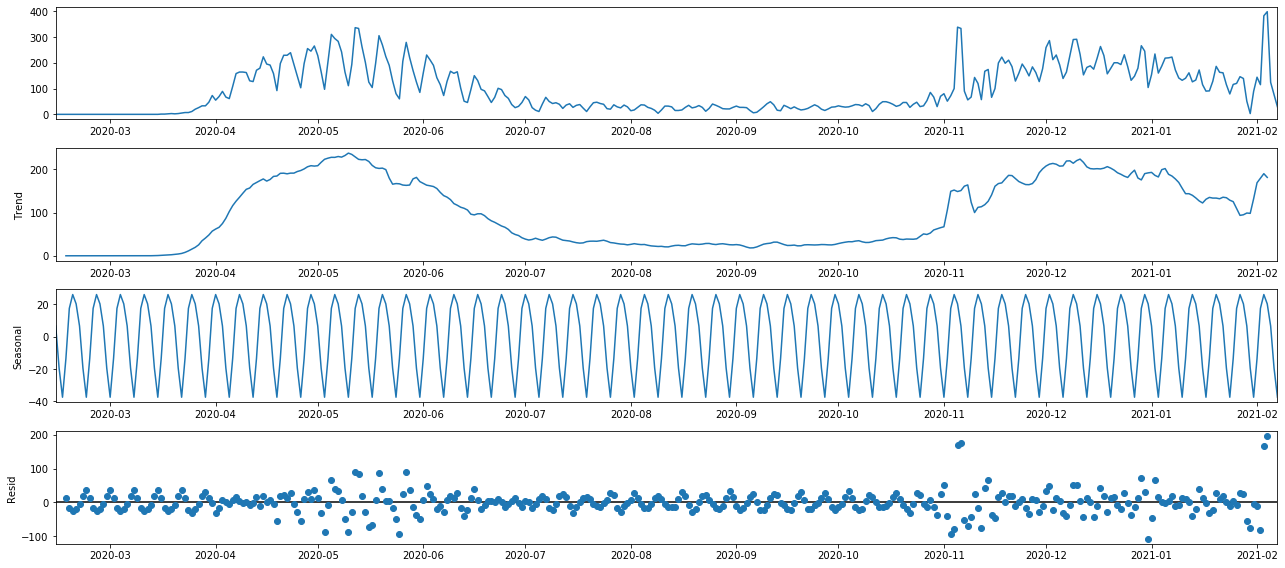

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 30)30 - AIC:4519.962170925798
ARIMA(0, 0, 0)x(0, 0, 1, 30)30 - AIC:3963.5717544482177
ARIMA(0, 0, 0)x(0, 1, 0, 30)30 - AIC:3966.26375078975


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 30)30 - AIC:3611.8714162638234
ARIMA(0, 0, 0)x(1, 0, 0, 30)30 - AIC:3947.5382841842215


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 30)30 - AIC:3923.2771221567255


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 30)30 - AIC:3626.2882398702786


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 30)30 - AIC:3570.8681930891507


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 30)30 - AIC:4053.3630296728074


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 30)30 - AIC:3594.3131001343054


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 30)30 - AIC:3602.8907498001945


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 30)30 - AIC:3247.605495637186


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 30)30 - AIC:3583.711197638291


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 30)30 - AIC:3563.410620744861


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 30)30 - AIC:3304.466421680824


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 30)30 - AIC:3249.4148674365965
ARIMA(0, 1, 0)x(0, 0, 0, 30)30 - AIC:3746.430651036466


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 30)30 - AIC:3461.361125435981
ARIMA(0, 1, 0)x(0, 1, 0, 30)30 - AIC:3665.2409384352713


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 30)30 - AIC:3198.8514175378286
ARIMA(0, 1, 0)x(1, 0, 0, 30)30 - AIC:3471.189317824005


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 30)30 - AIC:3463.359917687081


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 30)30 - AIC:3294.736574825243


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 30)30 - AIC:3200.2365596000946
ARIMA(0, 1, 1)x(0, 0, 0, 30)30 - AIC:3673.481086085736


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 30)30 - AIC:3394.556852335827


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 30)30 - AIC:3592.2795803486047


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 30)30 - AIC:3123.9755370515904


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 30)30 - AIC:3413.506142710685


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 30)30 - AIC:3396.416578485668


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 30)30 - AIC:3226.776928429559


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 30)30 - AIC:3125.4667121192097
ARIMA(1, 0, 0)x(0, 0, 0, 30)30 - AIC:3747.0668123314


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 30)30 - AIC:3464.1366470203325


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 30)30 - AIC:3642.444227683053


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 30)30 - AIC:3190.3994927409613


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 30)30 - AIC:3464.2481350762996


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 30)30 - AIC:3466.1360809421603


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 30)30 - AIC:3275.06092336493


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 30)30 - AIC:3192.1198596865597
ARIMA(1, 0, 1)x(0, 0, 0, 30)30 - AIC:3652.2153715196805


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 30)30 - AIC:3377.676390059185


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 30)30 - AIC:3512.023824701342


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 30)30 - AIC:3080.5866989465662


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 30)30 - AIC:3386.9507627062294


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 30)30 - AIC:3379.663041984174


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 30)30 - AIC:3170.9594545282816


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 30)30 - AIC:3082.5844688336156
ARIMA(1, 1, 0)x(0, 0, 0, 30)30 - AIC:3741.5431107535733


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 30)30 - AIC:3457.749962173606
ARIMA(1, 1, 0)x(0, 1, 0, 30)30 - AIC:3655.071175481877


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 30)30 - AIC:3192.2290153184786


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 30)30 - AIC:3457.885577225812


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 30)30 - AIC:3459.7445808633006


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 30)30 - AIC:3272.4179229668734


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 30)30 - AIC:3193.575738664952
ARIMA(1, 1, 1)x(0, 0, 0, 30)30 - AIC:3616.7799188435165


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 30)30 - AIC:3342.844604337192


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 30)30 - AIC:3543.2826640408025


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 30)30 - AIC:3083.9619600668293


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 30)30 - AIC:3352.1304571481373


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 30)30 - AIC:3344.773073944195


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 30)30 - AIC:3177.1210514040986


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 30)30 - AIC:3088.2257982457177


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


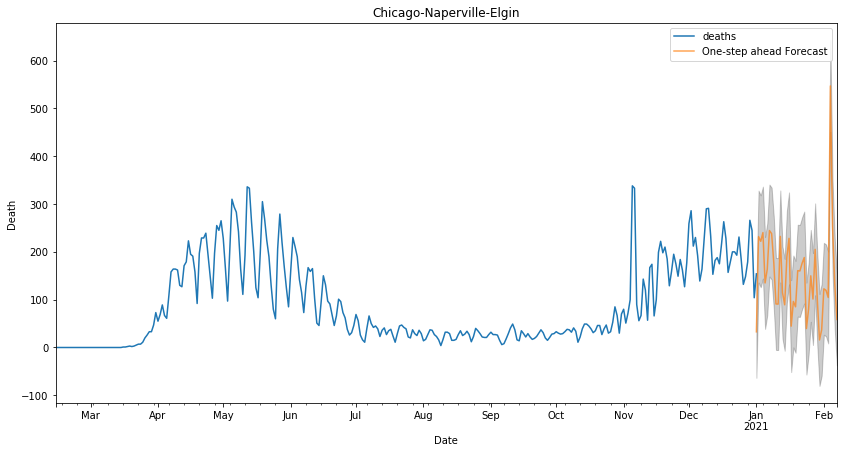

In [869]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
import math
import numpy as np
from pandas import concat
from pandas import DataFrame
from pandas import Series
from math import sqrt
#from pandas import datetime
#from datetime import timedelta
from datetime import datetime, timedelta

import statsmodels.api as sm
from pylab import rcParams
import itertools


if __name__ == "__main__":
    
    beginDate = dt.datetime(2020, 3, 18)
    endDate = dt.datetime(2021, 2, 7)
    
    input_MSA = 'Chicago-Naperville-Elgin'
    
    #LSTM_test(input_MSA)
    
    #LSTM_test1(input_MSA)
    
    #simple_plot(input_MSA, beginDate, endDate)
    
    #linear_regression(input_MSA)
    
    ARIMA_test(input_MSA)


    